This notebook simulates a minimal model of sequential activation of encoded memory items on a Hopfield-like network. In this model each learned state is a dynamically stable ‘pattern’ made of two active units coding for populations of neurons in the neural network, the others units being inactive. Moreover, these patterns can be destabilized under the effect of short term synaptic depression (STD), hence allowing for dynamics of activation of patterns
in the network state space. Details on the model can be found in the refenences below. 

The equations for the units are derived from (Amari 1972), in which the membrane potential $u_i$ of each unit $i$ is replaced by the activity $x_i=S(u_i)=1/(1+e^{-\gamma u_i})$ (Chossat and Krupa 2016). The variables are now the activities which take values in the interval $[0,1]$ after $S^{-1}(x_i)$ has been replaced by its polynomial expansion. The equation for unit $i$ reads
$$
\dot{x_i} = x_i(1-x_i)\left(-\frac{4}{\gamma} x_i + \sum_{j=1}^N J_{i,j} x_j - \lambda\sum_{j=1}^N x_j - \lambda\nu_ix_i\right) + \eta
$$
where $\gamma$ is the gain and $\lambda$ is the inhibitory coefficient. The coefficient $\nu_i$ accounts for the possibility of short-range inhibition. Note that $x_i=0$ or $1$ are always solutions of \eqref{eq:x}. The strength of the connection from units $j$ to $i$ at time $t$ is given by $J_{ij}(t)=J_{ij}^{max} s_j(t)$, where $J_{ij}^{max}=\sum_k\xi^k_i\xi^k_j$ follows the Hebbian rule, and $s_j(t)$ follows the STD law as
$$
\tau_r \dot{s_i} = 1 - s_i - \rho s_i x_i,
$$
where $\tau_r$ is the recovery time constant and $\rho = \tau_r U$ with $U$ being the fraction of the synaptic resources. 


References: 
1. Amari (1972). Learning patterns and pattern sequences by self-organizing nets of threshold elements. IEEE Transactions. C (21): 1197–1206.
2. Hopfield (1982). "Neural networks and physical systems with emergent collective computational abilities". Proceedings of the National Academy of Sciences. 79 (8): 2554–2558.
3.  Hopfield (1984). "Neurons with graded response have collective computational properties like those of two-state neurons". Proceedings of the National Academy of Sciences. 81 (10): 3088–3092.
4. Chossat and Krupa (2016). Heteroclinic cycles in Hopfield networks. J. of Nonlinear Science 28(2), 471–491.
5. Aguilar, Chossat, Krupa and Lavigne (2017). Latching dynamics in neural networks with synaptic depression, PLoS ONE 12(8): e0183710.
6. Köksal-Ersöz, Aguilar, Chossat, Krupa and Lavigne (2020). Neuronal mechanisms for sequential activation of memory items: dynamics and reliability, PLoS ONE, 15(4): e0231165.
7. Köksal-Ersöz E, Chossat, Krupa and Lavigne (2022). Dynamic branching in a neural network model for probabilistic prediction of sequences. Journal of Computational Neuroscience, 50, 537–557.

Here we will express the firing rate $x_i$ in a more general form that will allow us to inversitgate population-specific properties:
$$ \dot{x_i} = x_i(1-x_i)\left(-\mu_i x_i -\lambda \sum_{j=1}^N x_j - \nu_i x_i + \sum_{j=1}^N J_{i,j}^{max} s_j x_j \right)+\eta$$
with:￼
- $\mu_i$: Inverse of neural gain
- $\lambda$: Global inhibition
- $\nu_i$￼: Local inhibition
- $\eta$: Noise

The notebook comes with a system of $N=10$ units and three different topologies of memory network: linear, branch, cycle. Our objective is to understand:
1. How does noise control activity?
2. How does coupling impact sequential activity or branching?
3. How does local gain impact branching or cycling?
4. How can you give a direction (or preference) to dynamics?


![Topologies](topology.png)

In [ ]:
import numpy as np
import time
from matplotlib import pyplot as plt

import parameterLists
import simu_E_g
import fromlist_loop
import activitity_analysis_test

colorList = ['blue','red', 'orange','purple','g','cyan','firebrick','magenta','brown', 'black']

# this line is to ensure reproducibility
np.random.seed(1283749292)


Combination :  [0.04, 300, 0.004, 0.6, 0.4]
Simulation number:  0
Simulation number:  1
Simulation number:  2
Simulation number:  3
Simulation number:  4
Completed in 2.8039698600769043 sec


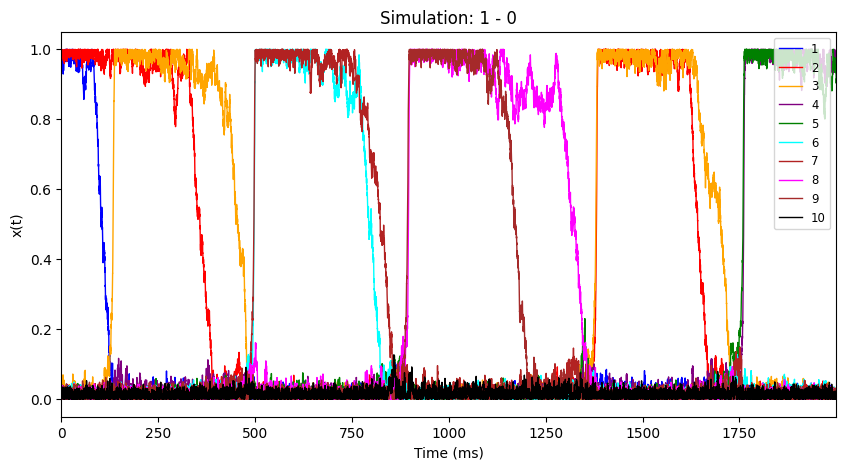

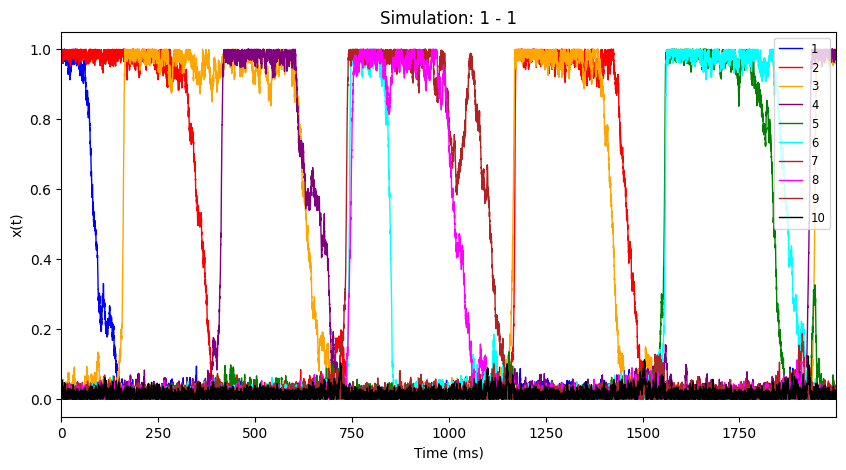

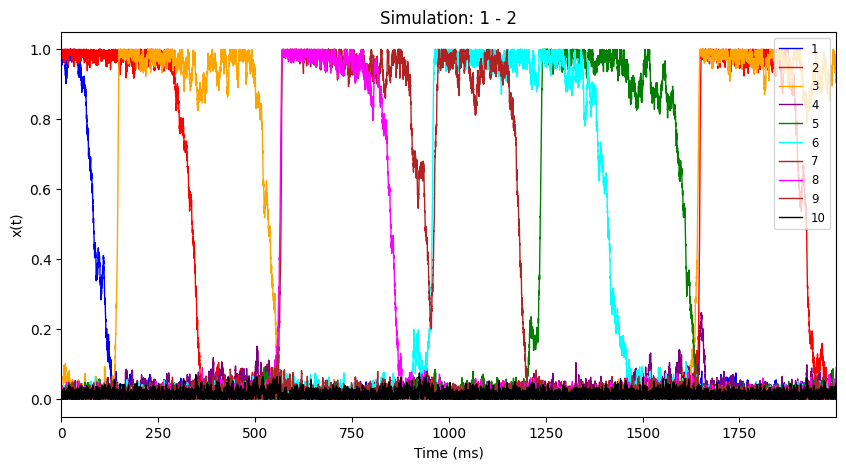

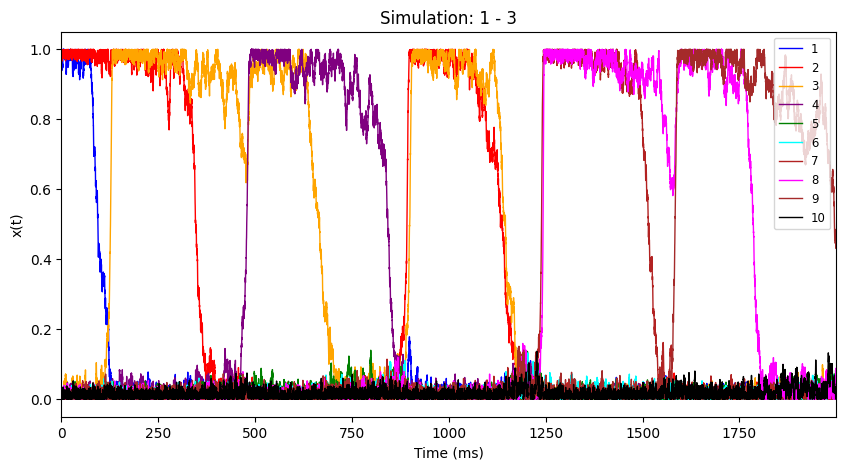

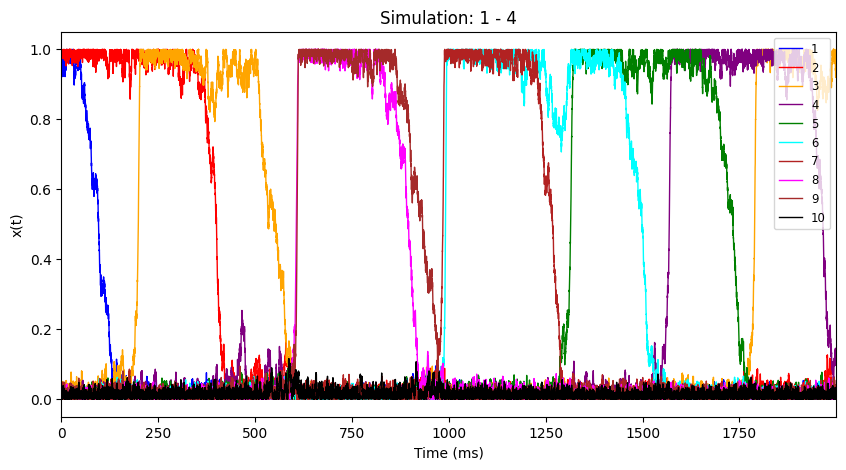

In [65]:
# choose the topology of the network
# 1: linear, 2: branch, 3: cycle
p = parameterLists.parameters_linear()  # create an instance of the parameters class
# p = parameterLists.parameters_branching()  # create an instance of the parameters class
# p = parameterLists.parameters_cycling()  # create an instance of the parameters class

# load the parameters
eta = p.liste_eta[0] # noise level
rho = p.liste_rho[0] # STD parameter
tau = p.liste_tau[0] # time scale of STD
u = rho/tau          
G = p.liste_G[0] # strength of inhibition
mu_global = p.liste_mu[0]   # inverse of neural gain
mu = np.ones(p.N) * mu_global

if p.branch_type == 2 or p.branch_type == 3:  # branching
    mu[1 + p.branch_unit[0]:] = p.liste_mu_change[0]  # change mu for the branch unit

print('Combination : ',[eta, tau, u, G, mu[0]])
time_start1 = time.time()         
last_unit_index = np.zeros(int(p.simulationspercombination))
next_unit_index = np.zeros(int(p.simulationspercombination))                                        
for n in range(0, int(p.simulationspercombination)):    
    print("Simulation number: ", n)
    # Run the simulation
    ts, xComplete = simu_E_g.simulation(p, eta, tau, u, mu, G)
    # Save the activity pattern
    simu_E_g.save_activity_pattern(ts, xComplete, p, eta, tau, u, mu, G, n)

    # Plot the activity pattern
    figure = plt.figure(figsize=(10, 5))
    for i in range(p.N):
        plt.title('Simulation: {} - {}'.format(p.branch_type, n))
        plt.plot(ts, xComplete[:,i], linewidth=1.0, color = colorList[i], label="{}".format(i+1))
        plt.xlim(0, ts[-1])
        plt.xlabel('Time (ms)')
        plt.ylabel('x(t)')
        plt.legend(loc = 'upper right', fontsize='small')

time_end1 = time.time()
print("Completed in {} sec".format(time_end1 - time_start1))  

# Analyze the activity pattern
pattern_initial, pattern_next, branch_initial, branch_next = activitity_analysis_test.execute(p, eta, tau, u, mu, G)

In [66]:
pattern_initial

[['B', 'C', 'B', 'C', 'B']]

In [67]:
branch_initial

array([[0., 0., 0., 0., 0.]])

In [68]:
pattern_next

[['F', 'F', 'G', 'B', 'H']]

In [69]:
branch_next 

array([[0., 0., 0., 0., 0.]])

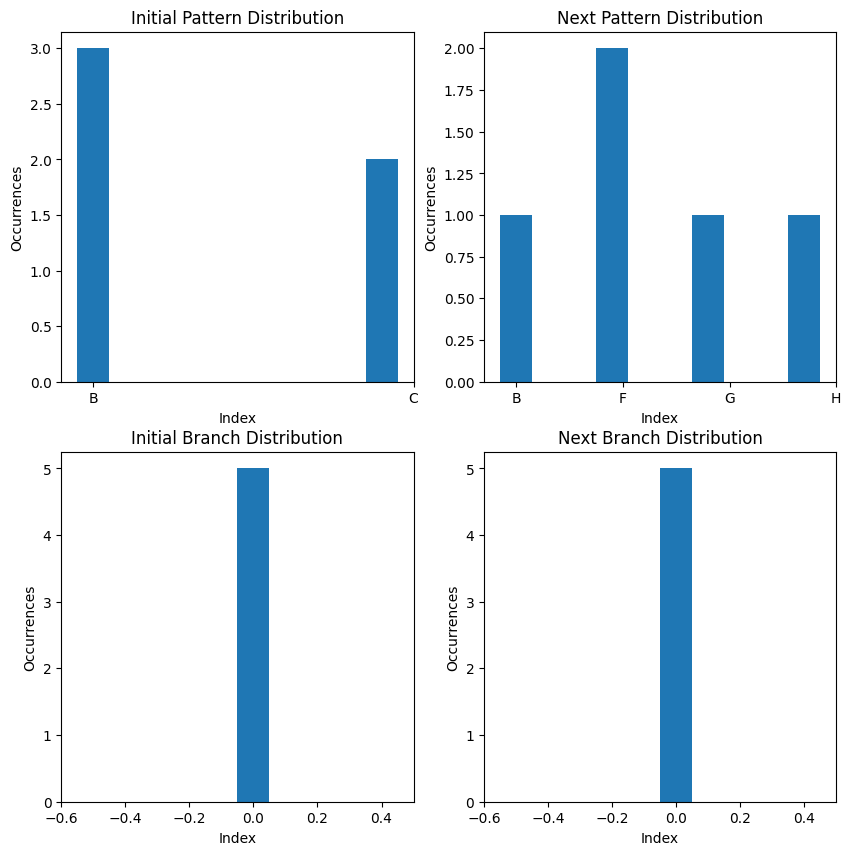

In [75]:
# histpgram plots of the initial and next patterns and branches
fig_hist, ax_hist = plt.subplots(2, 2, figsize=(10, 10))
ax_hist[0, 0].set_title('Initial Pattern Distribution')
ax_hist[0, 1].set_title('Next Pattern Distribution')
ax_hist[1, 0].set_title('Initial Branch Distribution')
ax_hist[1, 1].set_title('Next Branch Distribution') 
ax_hist[0, 0].hist(sorted(pattern_initial[0]), align='left')
ax_hist[0, 1].hist(sorted(pattern_next[0]), align='left')
ax_hist[1, 0].hist(branch_initial[0], align='left')
ax_hist[1, 1].hist(branch_next[0], align='left')
for ax in ax_hist.flat:
    ax.set_xlabel('Index')
    ax.set_ylabel('Occurrences') 
